In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
dfraw = pd.read_csv('../data/total_participant_data.csv')

In [46]:
dfraw

,ParticipantName,RecordingName,RecordingDate,FixationFilter,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,GazePointX (ADCSpx),...,EyePosRightY (ADCSmm),EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex,IRMarkerCount,IRMarkerID,PupilGlassesRight
0,P01,Rec 01,11/4/2019,I-VT filter,NaN,12.0,NaN,Unclassified,8.0,645.0,...,130.35,591.33,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN
1,P01,Rec 01,11/4/2019,I-VT filter,NaN,29.0,1.0,Fixation,733.0,644.0,...,130.36,591.30,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN
2,P01,Rec 01,11/4/2019,I-VT filter,NaN,46.0,1.0,Fixation,733.0,644.0,...,130.34,591.16,0.0,0.0,5.48,5.39,NaN,NaN,NaN,NaN
3,P01,Rec 01,11/4/2019,I-VT filter,NaN,62.0,1.0,Fixation,733.0,646.0,...,130.32,591.12,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN
4,P01,Rec 01,11/4/2019,I-VT filter,NaN,79.0,1.0,Fixation,733.0,645.0,...,130.33,591.22,0.0,0.0,5.47,5.38,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,Rec 01,12/6/2019,I-VT filter,NaN,730993.0,NaN,Saccade,50.0,907.0,...,152.90,642.30,0.0,0.0,4.33,3.97,2294.0,NaN,NaN,NaN
1888473,P29,Rec 01,12/6/2019,I-VT filter,NaN,731010.0,NaN,Saccade,50.0,1132.0,...,153.07,642.97,0.0,0.0,4.30,3.97,2294.0,NaN,NaN,NaN
1888474,P29,Rec 01,12/6/2019,I-VT filter,NaN,731026.0,NaN,Unclassified,25.0,1155.0,...,152.96,642.69,0.0,0.0,4.37,4.00,NaN,NaN,NaN,NaN
1888475,P29,Rec 01,12/6/2019,I-VT filter,NaN,731043.0,NaN,Unclassified,25.0,1150.0,...,152.94,642.71,0.0,0.0,4.35,4.00,NaN,NaN,NaN,NaN


#### Participant Naming Mistakes

In [ ]:
# Fix the mistakes in the ParticipantName column
def fix_participant_names(entry):
    if entry == 'P09':
        return 'P08'
    elif entry == 'P9':
        return 'P09'
    else:
        return entry

dfraw.ParticipantName = dfraw.ParticipantName.map(fix_participant_names)

#### Poor Calibrations

In [56]:
# Drop all entries from the participants whose eyes could not be identified 
# well by the eye trackier (particpants 16 and 19) in `par_data_total.ipynb
dfraw = dfraw[(dfraw.ParticipantName != 'P19') & (dfraw.ParticipantName != 'P16')]

#### Invalid Trials

In [52]:
# We get these manual removes from looking at the histograms of the fixation data and the 
# recording_data in `par_data_total.ipynb`

manual_remove = ['EATCJK', 'EUKMPA', 'GNSOAL', 'MLRNAO', 'YSMOTR', 'TENUAP', 
                 'UMKPAE', 'RWBON', 'WRNOB', 'NPTAUE', 'RSOYMT', 'LOMNAR']    

dfraw = dfraw.loc[~dfraw.MediaName.isin(['anagram_' + agrm + '.tiff' for agrm in manual_remove])]

#### Lazy Eye

In [ ]:
# Handle participant 12's lazy right eye
dfraw['GazePointX (ADCSpx)'] = np.where(dfraw.ParticipantName == 'P12', 
                            dfraw['GazePointLeftX (ADCSpx)'], dfraw['GazePointX (ADCSpx)'])

dfraw['GazePointY (ADCSpx)'] = np.where(dfraw.ParticipantName == 'P12', 
                            dfraw['GazePointLeftY (ADCSpx)'], dfraw['GazePointY (ADCSpx)'])

#### 5 and 6 Number Calibrations

In [99]:
max_timestamps = dict(dfraw.groupby(['ParticipantName']).RecordingTimestamp.max())

limited_recording_data = dfraw[['ParticipantName', 'RecordingTimestamp']]

def get_percent_recording(row):
    max_timestamp =  max_timestamps.get(row['ParticipantName'], np.nan)
    return row['RecordingTimestamp'] / max_timestamp

In [125]:
%%time
percent_recording = limited_recording_data.apply(get_percent_recording, axis=1)

CPU times: user 36 s, sys: 136 ms, total: 36.1 s
Wall time: 36.2 s


In [128]:
dfraw['PercentRecording'] = percent_recording

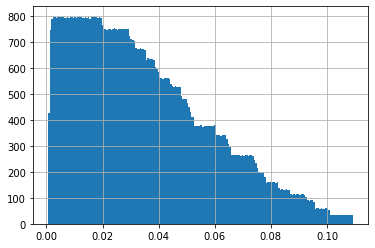

In [135]:
# When did the 5 number calibrations happen for each participant?
# Answer: Beginning
dfraw.loc[(dfraw.MediaName == '5_anagram_12345.tiff')]['PercentRecording'].hist(bins=200)

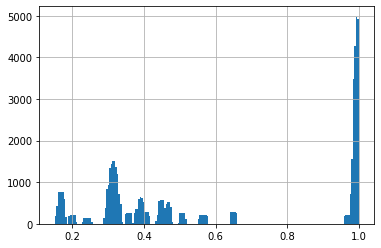

In [133]:
# When did the 6 number calibrations happen for each participant?
# Answer: Middle and End
dfraw.loc[(dfraw.MediaName == '6_anagram_123456.tiff')]['PercentRecording'].hist(bins=200)

In [145]:
# After 75% through the trial is a safe cut off to get 
# the ending 6 calibration
dfraw.loc[(dfraw.MediaName == '6_anagram_123456.tiff') &
          (dfraw['PercentRecording'] > 0.72)].sort_values(
    by='PercentRecording')['PercentRecording'].head()

1842525    0.957354
1842526    0.957374
1842527    0.957395
1842528    0.957415
1842529    0.957436
Name: PercentRecording, dtype: float64

In [147]:
dfraw.columns

Index(['ParticipantName', 'RecordingName', 'RecordingDate', 'FixationFilter',
       'MediaName', 'RecordingTimestamp', 'FixationIndex', 'GazeEventType',
       'GazeEventDuration', 'GazePointX (ADCSpx)', 'GazePointY (ADCSpx)',
       'GazePointLeftX (ADCSpx)', 'GazePointLeftY (ADCSpx)',
       'GazePointRightX (ADCSpx)', 'GazePointRightY (ADCSpx)',
       'FixationPointX (MCSpx)', 'FixationPointY (MCSpx)',
       'GazePointX (MCSpx)', 'GazePointY (MCSpx)', 'CamLeftX', 'CamLeftY',
       'CamRightX', 'CamRightY', 'DistanceLeft', 'DistanceRight',
       'EyePosLeftX (ADCSmm)', 'EyePosLeftY (ADCSmm)', 'EyePosLeftZ (ADCSmm)',
       'EyePosRightX (ADCSmm)', 'EyePosRightY (ADCSmm)',
       'EyePosRightZ (ADCSmm)', 'ValidityLeft', 'ValidityRight', 'PupilLeft',
       'PupilRight', 'SaccadeIndex', 'IRMarkerCount', 'IRMarkerID',
       'PupilGlassesRight', 'PercentRecording'],
      dtype='object')

In [144]:
dfraw

,ParticipantName,RecordingName,RecordingDate,FixationFilter,MediaName,RecordingTimestamp,FixationIndex,GazeEventType,GazeEventDuration,GazePointX (ADCSpx),...,EyePosRightZ (ADCSmm),ValidityLeft,ValidityRight,PupilLeft,PupilRight,SaccadeIndex,IRMarkerCount,IRMarkerID,PupilGlassesRight,PercentRecording
0,P01,Rec 01,11/4/2019,I-VT filter,NaN,12.0,NaN,Unclassified,8.0,645.0,...,591.33,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,0.000013
1,P01,Rec 01,11/4/2019,I-VT filter,NaN,29.0,1.0,Fixation,733.0,644.0,...,591.30,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,0.000031
2,P01,Rec 01,11/4/2019,I-VT filter,NaN,46.0,1.0,Fixation,733.0,644.0,...,591.16,0.0,0.0,5.48,5.39,NaN,NaN,NaN,NaN,0.000049
3,P01,Rec 01,11/4/2019,I-VT filter,NaN,62.0,1.0,Fixation,733.0,646.0,...,591.12,0.0,0.0,5.49,5.38,NaN,NaN,NaN,NaN,0.000067
4,P01,Rec 01,11/4/2019,I-VT filter,NaN,79.0,1.0,Fixation,733.0,645.0,...,591.22,0.0,0.0,5.47,5.38,NaN,NaN,NaN,NaN,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888472,P29,Rec 01,12/6/2019,I-VT filter,NaN,730993.0,NaN,Saccade,50.0,907.0,...,642.30,0.0,0.0,4.33,3.97,2294.0,NaN,NaN,NaN,0.999932
1888473,P29,Rec 01,12/6/2019,I-VT filter,NaN,731010.0,NaN,Saccade,50.0,1132.0,...,642.97,0.0,0.0,4.30,3.97,2294.0,NaN,NaN,NaN,0.999955
1888474,P29,Rec 01,12/6/2019,I-VT filter,NaN,731026.0,NaN,Unclassified,25.0,1155.0,...,642.69,0.0,0.0,4.37,4.00,NaN,NaN,NaN,NaN,0.999977
1888475,P29,Rec 01,12/6/2019,I-VT filter,NaN,731043.0,NaN,Unclassified,25.0,1150.0,...,642.71,0.0,0.0,4.35,4.00,NaN,NaN,NaN,NaN,1.000000


In [96]:
a = dfraw['RecordingTimestamp']

In [97]:
a.index = dfraw.ParticipantName

In [106]:
a.sort_values()

ParticipantName
P27          0.0
P11          1.0
P09          2.0
P12          2.0
P29          3.0
         ...    
P17    1405459.0
P17    1405476.0
P17    1405493.0
NaN          NaN
NaN          NaN
Name: RecordingTimestamp, Length: 1709819, dtype: float64

In [ ]:
def get_percent_of_recording(entry):
    return 

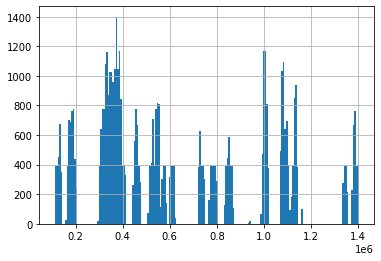

In [82]:
dfraw.loc[(dfraw.MediaName == '6_anagram_123456.tiff')].RecordingTimestamp.hist(bins=200)



In [81]:
160_000 / 60_000

2.6666666666666665

In [78]:
100_000 / 60_000

1.6666666666666667

In [69]:
67000 / 60_000

1.1166666666666667

In [64]:
dfraw.MediaName.unique()

array([nan, 'anagram_123456.tiff', 'anagram_LEADFW.tiff',
       'anagram_SCODLE.tiff', 'anagram_ARDIEM.tiff',
       'anagram_IUJONR.tiff', 'anagram_RYEABT.tiff',
       'anagram_PNEUTA.tiff', 'anagram_MDTOSE.tiff',
       'anagram_KUMEPA.tiff', 'anagram_ASONLG.tiff',
       'anagram_OYSMTR.tiff', 'anagram_LMOARN.tiff',
       'anagram_AETCJK.tiff', 'anagram_AFDWLE.tiff',
       'anagram_CEOLDS.tiff', 'anagram_IAMEDR.tiff',
       'anagram_NOJUIR.tiff', 'anagram_ETABYR.tiff',
       'anagram_NAUPTE.tiff', 'anagram_ODTEMS.tiff',
       'anagram_WFEADL.tiff', 'anagram_CSOELD.tiff',
       'anagram_RAIMED.tiff', 'anagram_JIUORN.tiff',
       'anagram_YRBATE.tiff', 'anagram_OSMDTE.tiff',
       'anagram_UAPEKM.tiff', 'anagram_NLASOG.tiff',
       'anagram_OMRLNA.tiff', 'anagram_AEJKTC.tiff',
       'anagram_LAEFDW.tiff', 'anagram_ELCSDO.tiff',
       'anagram_DIEMAR.tiff', 'anagram_INOJRU.tiff',
       'anagram_ATEYRB.tiff', 'anagram_TNPUAE.tiff',
       'anagram_OTEMDS.tiff', 'anagram_KP

In [ ]:
total_data.gen_gazeY = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftY (ADCSpx)'], \
                                total_data.gen_gazeY)

In [ ]:
# Replace the gen_gazeX and gen_gazeY entries for participant 12 with their
# left eye data because - due to participant
# 12's lazy right eye - the right eye calibration was way off

total_data.gen_gazeX = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftX (ADCSpx)'], \
                                total_data.gen_gazeX)

total_data.gen_gazeY = np.where(total_data.ParticipantName == 'P12', total_data['GazePointLeftY (ADCSpx)'], \
                                total_data.gen_gazeY)

In [61]:
for col in dfraw.select_dtypes('float64'):
    print(col, dfraw[col].var())

RecordingTimestamp 112934162801.33096
FixationIndex 981651.5833947025
GazeEventDuration 1130034.6645955602
GazePointX (ADCSpx) 150603.94340556857
GazePointY (ADCSpx) 105690.42062976985
GazePointLeftX (ADCSpx) 147626.06273877327
GazePointLeftY (ADCSpx) 104873.57836597593
GazePointRightX (ADCSpx) 157109.8638178792
GazePointRightY (ADCSpx) 106648.51061497797
FixationPointX (MCSpx) 143848.00519834485
FixationPointY (MCSpx) 103286.64850278736
GazePointX (MCSpx) 141647.68715256726
GazePointY (MCSpx) 100968.80379795509
CamLeftX nan
CamLeftY nan
CamRightX nan
CamRightY nan
DistanceLeft 2664.0985288869597
DistanceRight 4929.427662828265
EyePosLeftX (ADCSmm) 385.71777094717527
EyePosLeftY (ADCSmm) 546.2207974495675
EyePosLeftZ (ADCSmm) 2720.372688012045
EyePosRightX (ADCSmm) 407.88508009952403
EyePosRightY (ADCSmm) 2383.9828817748275
EyePosRightZ (ADCSmm) 2659.8513982644663
ValidityLeft 1.0700540340882023
ValidityRight 1.0808490372716295
PupilLeft 0.29293213518176126
PupilRight 0.308636467495246